# Olympics EDA Final

Zachary Lewis

This is an analysis of Olympic events from 1986 to 2016 provided as part of the course curriculum. The goal of my analysis is to review medal awards, demographic breakdown, and trends.

## Import Libraries and Set Notebook Defaults:

In [2]:
# @title
# Import libraries for analysis
import pandas as pd
!pip install pyspark
!pip install --upgrade plotly
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from IPython.display import display
from google.colab import data_table
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

%matplotlib inline

# Fully display all columns in dataframes
pd.set_option('display.max.columns', None)
pd.set_option('display.max.rows', None)

# Connect with Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Assign csv files to dataframes
df1 = pd.read_csv('/content/drive/MyDrive/Newman/Descriptive Analytics/Olympics EDA /data/athlete_events.csv', sep =',', header = 'infer')
df2 = pd.read_csv ('/content/drive/MyDrive/Newman/Descriptive Analytics/Olympics EDA /data/noc_regions.csv', sep = ',', header = 'infer')

# Assign dataframe variable names for data cleaning
athletes_cleaned = df1
regions_cleaned = df2

# Function to capitalize values with apostrophes
def apostrophe(text):
  # Function splits values from "-"
  # then reassembles it after capitalizing the value
  # allowing values with apostrophes to be capitalized without
  # capitalizing the letter after an apostrophe
    words = text.split()
    new_words = []
    for word in words:
        if "-" in word:
            parts = word.split("-")
            new_word = parts[0].capitalize() + "-" + parts[1]
        else:
            new_word = word.capitalize()
        new_words.append(new_word)
    return " ".join(new_words)

# Function to captitalize values with hyphens
def hyphens(text):
  # Function capitalizes letters after hyphens
  # by splitting it and reassembling the value
    words = text.split()
    capitalized_words = []
    for word in words:
        if '-' in word:
            hyphenated_words = word.split('-')
            capitalized_hyphenated_words = [w.capitalize() for w in hyphenated_words]
            capitalized_words.append('-'.join(capitalized_hyphenated_words))
        else:
            capitalized_words.append(word.capitalize())
    return ' '.join(capitalized_words)


import re

# Function to capitalize values with words after parenthesis
def capitalize_after_paren(text):
    return re.sub(r'\(([\w\s]+)', lambda match: '(' + ' '.join(word.capitalize() for word in match.group(1).split()), text)

# Apply functions to  athletes_cleaned 'Event' column
athletes_cleaned.Event = athletes_cleaned.Event.apply(apostrophe)
athletes_cleaned.Event = athletes_cleaned.Event.apply(hyphens)
athletes_cleaned.Event = athletes_cleaned.Event.apply(capitalize_after_paren)

# Replace erroneous/missing characters within the column
athletes_cleaned = athletes_cleaned.replace("Luge Mixed (Men)'s Doubles", "Luge Mixed Men's Doubles")
athletes_cleaned = athletes_cleaned.replace("Tug-Of Men's Tug-Of", "Tug-Of-War Men's Tug-Of-War")

# Remove unrealistic attributes from dataframe
athletes_cleaned = athletes_cleaned[(athletes_cleaned["Height"] > 50) & (athletes_cleaned["Weight"] > 20) & (athletes_cleaned["Age"] > 10)]

# Fill all null values in athletes_cleaned and changes 'Age' datatype to int
athletes_cleaned.loc[:, "Height"] =  athletes_cleaned["Height"].fillna(0)
athletes_cleaned.loc[:, "Weight"] =  athletes_cleaned["Weight"].fillna(0)
athletes_cleaned.fillna({'Medal': 'N/A'}, inplace=True)
athletes_cleaned.Age =  athletes_cleaned.Age.fillna(0).astype(int)

# Fill all null values in regions_cleaned
regions_cleaned.notes = np.where(df2.notes.isna(), 'N/A', df2.notes)
regions_cleaned.loc[208, "region"] = 'Oceania'
regions_cleaned.loc[168, "region"] = 'Displaced'
regions_cleaned.loc[213, "region"] = 'Unknown'

# Capitalize column names in regions_cleaned
regions_cleaned.rename(columns={'region' : 'Region', 'notes' : 'Notes'}, inplace=True)

# Simplify df names for analysis
athletes = athletes_cleaned
regions = regions_cleaned


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 73.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1
Mounted at /content/drive


## About This Data Set:

Data originated from two CSV documents: `athlete_events.csv` and `noc_regions.csv`.

The following columns are within `athlete_events`:

* ID - Unique identifiers for athletes
* Name - Full names of athletes
* Sex - Sexes/genders of athletes                
* Age - Ages of athletes      
* Height - Height of athletes                
* Weight  - Weight of athletes            
* Team - Team names of athletes            
* NOC - Country designation by the National Olympic Committee                 
* Games - Summer/Winter Olympic games              
* Year - Year of the event                  
* Season - Season of the event                  
* City - Venue of the event                  
* Sport  - Sports athletes participated in                 
* Event  - Events athletes participated in                 
* Medal - Medals received ("Bronze", "Silver, "Gold", "N/A")        

The following columns are within `noc_regions`:

* NOC - Country designation of the National Olympic Committee
* Region - Region of team
* Notes - Comments for additional context regarding teams


In [ ]:
# @title
gen_total = athletes.loc[:,['ID','Sex']].drop_duplicates()
gender_count = gen_total.ID.count()
male_count = gen_total.Sex[gen_total['Sex'] == 'M'].count()
female_count = gen_total.Sex[gen_total['Sex'] == 'F'].count()
noc_count = regions.NOC.drop_duplicates().count()
region_count = regions.Region.drop_duplicates().count()
team_count = athletes.Team.drop_duplicates().count()
year_count = athletes.Year.drop_duplicates().count()
medal_count = athletes.Medal[athletes['Medal'] != 'N/A'].count()
bronze_count = athletes.Medal[athletes['Medal'] == 'Bronze'].count()
silver_count = athletes.Medal[athletes['Medal'] == 'Silver'].count()
gold_count = athletes.Medal[athletes['Medal'] == 'Gold'].count()
min_age = athletes.Age.min()
max_age = athletes.Age.max()
city_count = athletes.City.drop_duplicates().count()
event_count = athletes.Event.drop_duplicates().count()
sport_count = athletes.Sport.drop_duplicates().count()


data = {
    "Category": [
        "Total Athletes", "Male Athletes", "Female Athletes", "NOCs", "Regions",
        "Teams", "Years", "Total Medals", "Bronze Medals", "Silver Medals", "Gold Medals",
        "Min Age", "Max Age", "Cities", "Events", "Sports"
    ],
    "Count": [
        gender_count, male_count, female_count, noc_count, region_count,
        team_count, year_count, medal_count, bronze_count, silver_count, gold_count,
        min_age, max_age, city_count, event_count, sport_count
    ]
}

df_summary = pd.DataFrame(data)

# Transpose the DataFrame so categories are columns
df_summary_transposed = df_summary.set_index("Category").T
display(df_summary_transposed)

Category,Total Athletes,Male Athletes,Female Athletes,NOCs,Regions,Teams,Years,Total Medals,Bronze Medals,Silver Medals,Gold Medals,Min Age,Max Age,Cities,Events,Sports
Count,99088,69279,29809,230,209,660,35,30181,10148,9866,10167,11,71,42,590,56


After accounting for duplicate cases and null cases, the dataset spans 35 years between 1896 and 2016. It contains basic demographic information on 99,088 athletes (69,279 male, 29,809 female). There are 206 National Olympic Committee designations (NOCs), 660 teams spread across 209 regions. It shows a total of 30181 medal awards from 590 events and 56 sports.

In [19]:
# @title
# Create a count of medals by year and assign it to medal_tally
na_remove = athletes[athletes['Medal'] != 'N/A']
medal_tally = na_remove.groupby("Year")["Medal"].count().reset_index()

# Returns a count of medals by NOC sorts by largest values
athletes.groupby("NOC")["Medal"].count().sort_values(ascending=False).head(10)

# Assign the columns Age and Medal to age_medal_dist after removing non medal winners
age_medal_dist = athletes.loc[athletes["Medal"] != 'N/A', ["Age", "Medal"]]

# Count athletes through Sex by Year incorporate ID to remove duplicate cases and place data in a pivot table
gender_participation = athletes.groupby(["Year", "Sex"])["ID"].nunique().unstack()




## Total Number of Medals Awarded per Country Between 1896 and 2016

In [178]:
# @title

# Create pivot table for medals by NOC
medals = athletes.pivot_table(index='NOC', columns='Medal', aggfunc='size', fill_value=0)

# Omit 'N/A' column from the pivot table
if 'N/A' in medals.columns:
  medals = medals.drop(columns=['N/A'])

# Create a Total column for the pivot table
medals['Total'] = medals.sum(axis=1)

# Rank data by Total with the smallest value ranked highest
medals['Rank by Total'] = medals['Total'].rank(ascending=False, method='min').astype(int)

# Sort table by Rank
medals.sort_values(['Rank by Total'], inplace=True)

# Reset the index of the table
medals = medals.reset_index()

# Omits rows without medals i.e. null values
medals = medals[(medals['Gold'] > 0) | (medals['Silver'] > 0) | (medals['Bronze'] > 0)]

# Create bar plot with results
fig = px.bar(medals, x='NOC', y=['Gold', 'Silver', 'Bronze'],
             color_discrete_sequence=['Gold', 'Silver', 'Brown'],
             labels = {'NOC': 'Country', 'value' : '# of Medals', 'variable': 'Medals'},
             title='Number of Medals per Country Between 1896 & 2016')
fig.show()

A bar graph provides a count of countries with medalists over the past 35 years. United States has the most medal wins by a wide margin. They are followed by Soviet Union, Germany, Australia, Russia, Canada, Italy, Great Britain, & France.

In [179]:
# @title




# Date ranges for the for loop
date_ranges = [(1896, 1919), (1920, 1929), (1930, 1939), (1940, 1949),
               (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989),
               (1990, 1999), (2000, 2009), (2010, 2016)]

# Calculate total medals per NOC

for start_year, end_year in date_ranges:
  years = list(range(start_year, end_year + 1))

  # Assign athletes with date filters to athyear
  athyear = athletes[(athletes['Year'] >= start_year) & (athletes['Year'] <= end_year)]

  # Create pivot table for medal count / drop 'N/A' column
  medals = athyear.pivot_table(index='NOC', columns='Medal', aggfunc='size', fill_value=0)

  if 'N/A' in medals.columns:
    medals = medals.drop(columns=['N/A'])
  medals['Total'] = medals.sum(axis=1)

  # Create ranking order and reset table index
  medals['Rank by Total'] = medals['Total'].rank(ascending=False, method='min').astype(int)
  medals.sort_values(['Rank by Total'], inplace=True)
  medals = medals.reset_index()

  # Filter rows with no medals
  medals = medals[(medals['Gold'] > 0) | (medals['Silver'] > 0) | (medals['Bronze'] > 0)]

  # Create bar graph with Gold, Silver, and Bronze rankings per Country
  fig = px.bar(medals, x='NOC', y=['Gold', 'Silver', 'Bronze'],
            color_discrete_sequence=['Gold', 'Silver', 'Brown'],
            labels = {'NOC': 'Country', 'value' : '# of Medals', 'variable': 'Medals'},
            title=f'Number of Medals per Country Between {start_year} & {end_year}'
            )

  # Display Graph
  fig.show()






Looking at counts within 10 year periods, the US has consistently remained in the top 3 in terms of medal wins often vying top positions with the USSR and Germany.

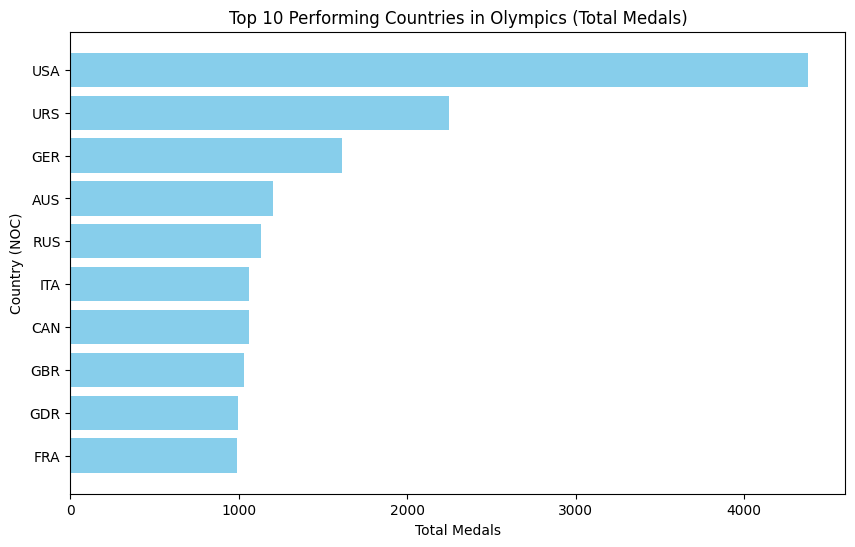

,NOC,Total Medals
0,USA,4383
1,URS,2246
2,GER,1612
3,AUS,1206
4,RUS,1134
5,ITA,1060
6,CAN,1060
7,GBR,1031
8,GDR,995
9,FRA,987


In [159]:
# @title
# Display top performing countries

# Filter out rows where Medal is not NaN (i.e., won a medal)
medal_winners = athletes.loc[athletes['Medal'] != 'N/A', ['NOC', 'Medal']]

# Count the total medals per country (NOC)
top_countries = medal_winners['NOC'].value_counts()

# Create a DataFrame for displaying
top_countries_df = pd.DataFrame({"NOC": top_countries.index, "Total Medals": top_countries.values})


top_10_countries = top_countries_df.head(10)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_10_countries["NOC"], top_10_countries["Total Medals"], color='skyblue')
plt.xlabel("Total Medals")
plt.ylabel("Country (NOC)")
plt.title("Top 10 Performing Countries in Olympics (Total Medals)")
plt.gca().invert_yaxis()  # Invert y-axis to have the top country at the top

# Show the plot
plt.show()


# Display the DataFrame
data_table.enable_dataframe_formatter()
top_countries_df


A clearer breakdown can be seen above with United States, the USSR, and Germany being the top 3 countries with the most medal wins.  

## Medal Tally Trends:

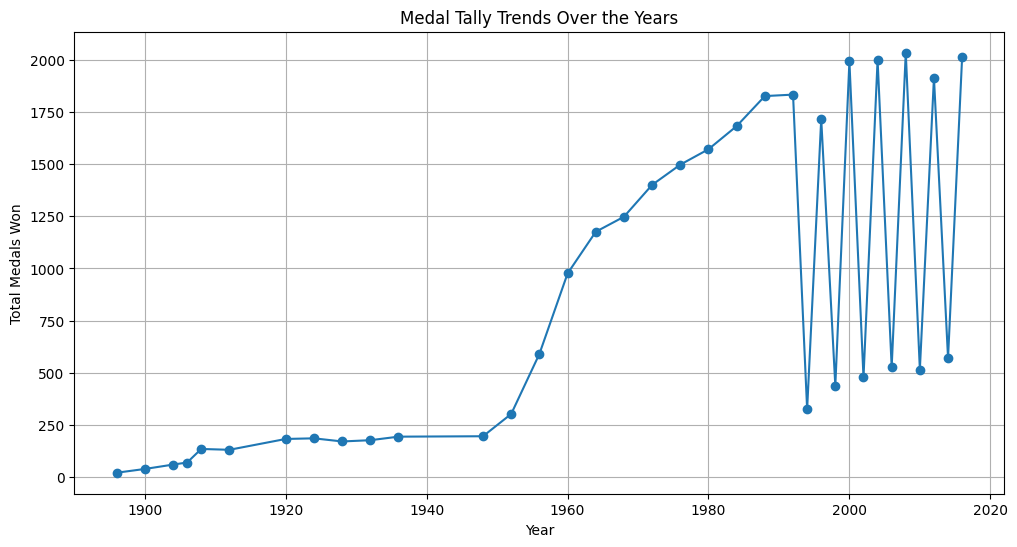

,Year,Medal
0,1896,20
1,1900,38
2,1904,59
3,1906,69
4,1908,134
5,1912,130
6,1920,182
7,1924,185
8,1928,170
9,1932,176


In [20]:
# @title
# Plot Medal Tally Trends
plt.figure(figsize=(12, 6))
plt.plot(medal_tally.Year, medal_tally.Medal, marker="o", linestyle="-")
plt.xlabel("Year")
plt.ylabel("Total Medals Won")
plt.title("Medal Tally Trends Over the Years")
plt.grid(True)
plt.show()
data_table.enable_dataframe_formatter()
medal_tally

Above are a medal trend line and the data table associated with the chart. The number of medals awarded was low before the 1950s with fluctations likely because of a lack of events and limited nation participation. There is a noticable increase in total awarded medals after the 1950s as events increased and new nations attended.

There is a lack of data points around 1916 and between 1940 to 1944 due to cancellations during the World War I and World War II.

Starting in early 2000s there are heavy fluctuations likely due to the Olympics running Summer and Winter games.

## Medal Tally Trends for Summer and Winter Olympics Over the Years

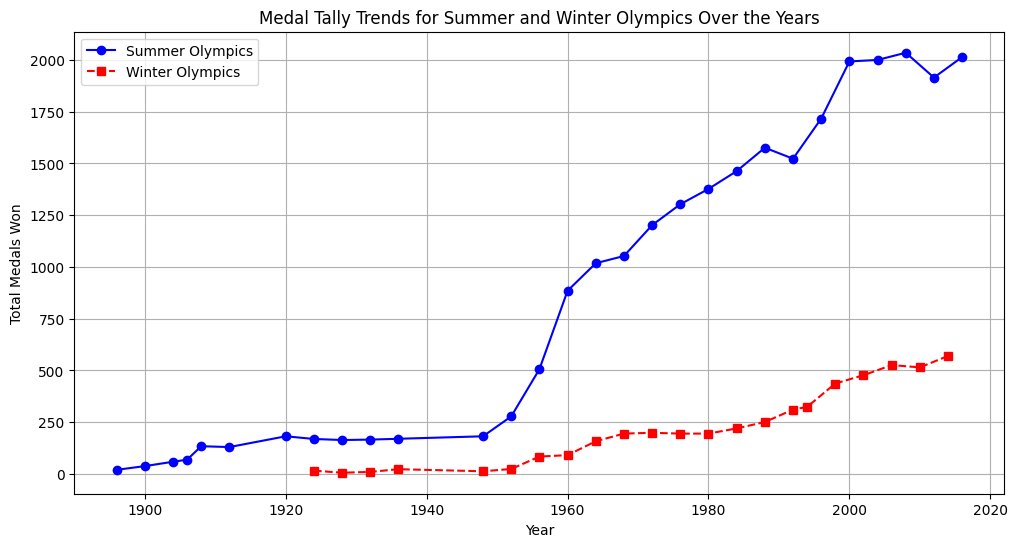

In [17]:
# @title

# Convert 'Year' column to numeric for filtering
athletes["Year"] = pd.to_numeric(athletes["Year"], errors="coerce")

# Remove 'N/A' values
na_remove = athletes[athletes['Medal'] != 'N/A']

# Identify Summer and Winter games separately
summer_games = na_remove[na_remove ["Season"] == "Summer"]
winter_games = na_remove[na_remove ["Season"] == "Winter"]

# Group by Year and count total medals awarded
summer_medal_trends = summer_games.groupby("Year")["Medal"].count().reset_index()
winter_medal_trends = winter_games.groupby("Year")["Medal"].count().reset_index()

# Create the line trend chart
plt.figure(figsize=(12, 6))

# Summer Olympics Trend
plt.plot(summer_medal_trends["Year"], summer_medal_trends["Medal"], marker='o', linestyle='-', label="Summer Olympics", color="blue")

# Winter Olympics Trend
plt.plot(winter_medal_trends["Year"], winter_medal_trends["Medal"], marker='s', linestyle='--', label="Winter Olympics", color="red")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("Total Medals Won")
plt.title("Medal Tally Trends for Summer and Winter Olympics Over the Years")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

A more in-depth look at medal tally trends by separating the games to Summer and Winter provides more stable trendlines. The rate of medals gain during the Summer games outpaced the Winter games most likely due to the Summer games having a larger number of competitive events.   

## Age vs. Medal Type Distribution

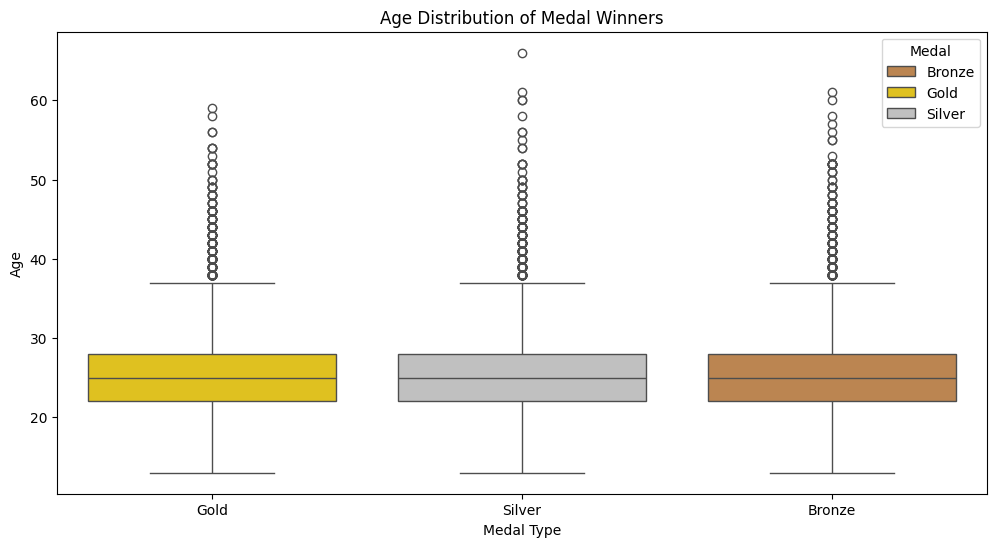

In [163]:
# @title
# Plot Age vs. Medal Type Distribution

# Create variable for color assignment
palette_colors = {
    "Gold": "gold",
    "Silver": "silver",
    "Bronze": "peru",
   }

# Create boxplot with x-axis for Medals, y-axis for Age
plt.figure(figsize=(12, 6))
sns.boxplot(x="Medal", y="Age", hue='Medal', data=age_medal_dist, order=["Gold", "Silver", "Bronze"],
legend=True, palette=palette_colors)
plt.xlabel("Medal Type")
plt.ylabel("Age")
plt.title("Age Distribution of Medal Winners")
plt.show()


A box plot provides a look at the average age of medalists with all within their mid 20s with most winners being under 40. There are several outliers extending from 40 over 60 years of age.

## Olympic Participation by Gender by Decade

In [ ]:
# @title
# Date ranges for the loop
date_ranges = [(1896, 1919), (1920, 1929), (1930, 1939), (1940, 1949),
               (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989),
               (1990, 1999), (2000, 2009), (2010, 2016)]

for start_year, end_year in date_ranges:
    # Filter dataset for the date range
    athyear = athletes[(athletes['Year'] >= start_year) & (athletes['Year'] <= end_year)]
    athratio = athyear[['Year', 'NOC', 'Sex']]

    # Check if there are entries before proceeding
    if athratio.empty:
        print(f"No data available for {start_year} - {end_year}")
        continue  # Skip this iteration if no data

    # Create pivot table
    gender_pivot = athratio.pivot_table(index='NOC', columns='Sex', aggfunc='size', fill_value=0)

    # Ensure 'M' and 'F' exist in the DataFrame
    if 'M' not in gender_pivot.columns:
        gender_pivot['M'] = 0
    if 'F' not in gender_pivot.columns:
        gender_pivot['F'] = 0

    # Add total and rank columns
    gender_pivot['Total'] = gender_pivot['M'] + gender_pivot['F']
    gender_pivot['Rank by Total'] = gender_pivot['Total'].rank(ascending=False, method='min').astype(int)
    gender_pivot.sort_values(['Rank by Total'], inplace=True)
    gender_pivot = gender_pivot.reset_index()

    # Create bar graph
    fig = px.bar(
        gender_pivot,
        x='NOC',
        y=['M', 'F'],
        color_discrete_sequence=['Light Blue', 'Pink'],
        labels={'NOC': 'Country', 'value': '# of Olympians', 'variable': 'Gender'},
        title=f'Olympians by Gender Between {start_year} & {end_year}'
    )

    # Display Graph
    fig.show()



<Figure size 1200x600 with 0 Axes>

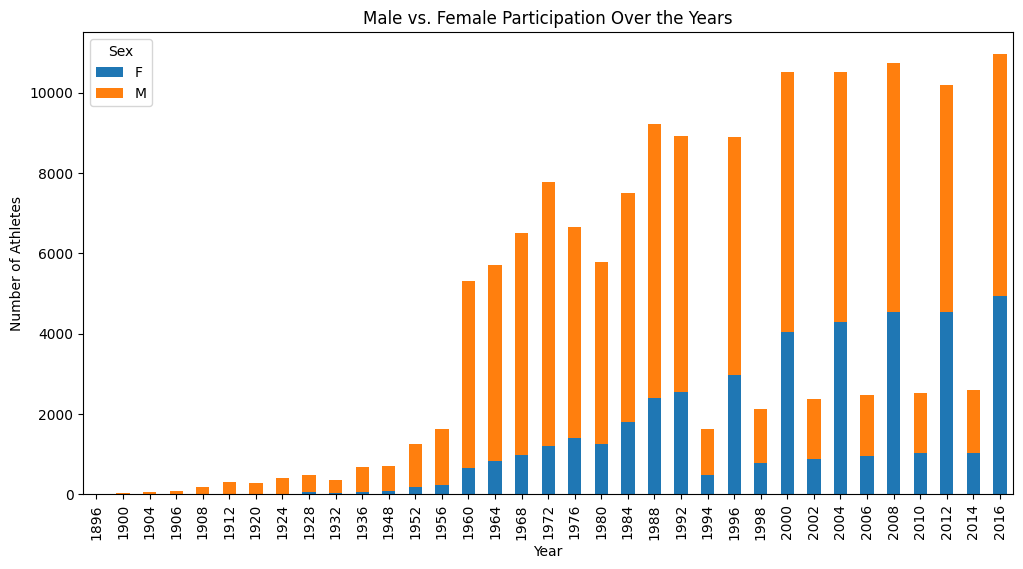

Sex,F,M
Year,,
1896,NaN,11.0
1900,NaN,34.0
1904,NaN,52.0
1906,NaN,77.0
1908,NaN,187.0
1912,NaN,302.0
1920,1.0,274.0
1924,5.0,403.0
1928,43.0,444.0


In [164]:
# @title
# Plot Male vs. Female Participation Trends
plt.figure(figsize=(12, 6))
gender_participation.plot(kind="bar", figsize=(12, 6), stacked=True)
plt.xlabel("Year")
plt.ylabel("Number of Athletes")
plt.title("Male vs. Female Participation Over the Years")
plt.legend(title="Sex")
plt.show()

data_table.enable_dataframe_formatter()
gender_participation

Looking at competitors by gender, at the onset of the games there was little to no female representation. This gradually shifted as time progressed to the point where most countries/events saw a near even split between male and female athletes.   

## Total Medals Awarded by Gender

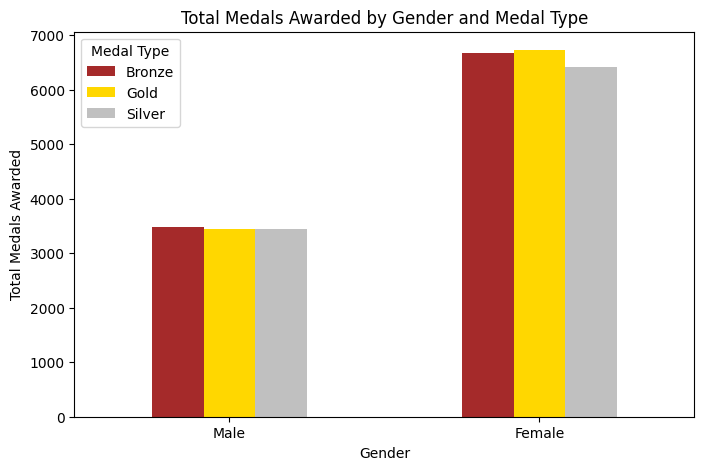

In [12]:
# @title
# Count medals awarded by gender and medal type

medals_by_gender_type = athletes.groupby(["Sex", "Medal"]).size().unstack(fill_value=0)

medals_by_gender_type.drop('N/A', axis=1, inplace=True)

# Create a bar chart segmented by medal type
medals_by_gender_type.plot(kind="bar", figsize=(8, 5), color=["brown", "gold", "silver"])

# Labels and title
plt.xlabel("Gender")
plt.ylabel("Total Medals Awarded")
plt.title("Total Medals Awarded by Gender and Medal Type")
plt.xticks(ticks=[0, 1], labels=["Male", "Female"], rotation=0)
plt.legend(title="Medal Type")

# Show the plot
plt.show()

Surprisingly, Women have earned the most medals despite their lack of representation in the Olympics during its nascent years.  

#Summary

Data shows the US outperformed all other nations in terms of amount of medals awarded between 1896 and 2016. Average age of medalists is mid 20s. Women saw a lack of representation in the games until the mid 90s. Despite the lack of representation during early years of the Olympics, women outpaced men in overall medal wins.   